# Lecture 5. Using Machine Learning for Treatment Effect Estimation

by Nadzeya Laurentsyeva @ nadzeya.laurentsyeva@econ.lmu.de


# 1. Introduction 

# Tools we have covered so far 

### Models to work with high-dimensional inputs
* Penalized regressions, e.g. Lasso
* Dimension-reduction tools, e.g. LSA, LDA

### Models to address nonlinearities in the data 
* CART and Random Forests 

### ML strength
* Prediction 

# How can these tools help economists? 

### Estimation of causal effects under unconfoundedness

* Model selection in case of high-dimensional covariates, e.g. post-double selection Lasso, double orthogonalization with Lasso
* Model specification for covariates, e.g. general double machine learning 
* **Estimation of treatment effects, e.g. doubly robust methods with machine learning**

### Estimation of heterogenous treatment effects 

* **Causal trees and forests**



# How can these tools help economists? 

### Approaches
* Separate prediction and causal inference tasks (e.g.  double machine learning)
* Adapt a ML method to allow for causal inference (e.g. causal trees and forests)

### Common principles 
* Cross-fitting / sub-sampling / honest estimation 
    * Use different samples for fitting the model and for estimating the parameters 
* Double orthogonalization 
* Theory-based estimator properties 
* Assumption: we observe all the relevant confounders  


# Overview of this lecture 
* Estimation of causal effects under unconfoundedness: treatment effects, doubly robust methods
<br>

* Estimation of heterogeneous treatment effects 
<br>

* Practical part: introduction to the EconML package in Python 
https://econml.azurewebsites.net/spec/motivation.html#motivating-examples

# Link to the previous lecture on causal inference

**Last time we focused on partial linear models**: 

$Y = D\theta_0 + g_0(Z) + U, E[U|Z,D] = 0$
where 

* $Y$ - outcome
* $D$ - policy/treatment variable with $\theta_0$ - the parameter of interest 
* $Z$ - (high-dimensional) vector of controls or confounders (nuisance parameters) in the sense that: 

$D = m_0(Z) + V, E[V|Z] = 0$

We used Lasso to estimate $\hat{m_0}(Z)$ and $\hat{g_0}(Z)$ when $Z$ is high-dimensional, residualized $Y$ and $D$ and obtained causal $\theta_0$. 

**Extensions/special cases**: 

* use cross-fitting to reduce bias from overfitting
* $m_0(Z)$ and $g_0(Z)$ can be nonlinear functions $\rightarrow$ estimate them with non-parametric methods (e.g. random forests)
* When $D$ is categorical and $g_0(D, Z)$ - $D$ is not additvely separable: estimate ATE
* Estimate heterogeneous treatment effects $\theta_0(Z)$


# 2. Estimation of treatment effects. Doubly robust methods 

# 2.1 Potential outcomes framework 

$Y = g_0(D, Z) + U, E[U|Z,D] = 0$
where 

* $Y$ - outcome
* $D$ - binary treatment $ \in \{0; 1\}$
* $Z$ - vector of controls or confounders (nuisance parameters) 

Note that $D$ does not have to be additively separable. 

$Y_i(0)$ and $Y_i(1)$ are potential outcomes of observation $i$, such that $Y_i = Y_i(D_i)$ (SUTVA, potential outcomes respond only to own treatment status)

We are interested in estimating the average treatment effect: 

$ ATE = E[Y_i(1) - Y_i(0)] $

Challenge: we do not observe $Y_i(1)$ and $Y_i(0)$ for the same $i$, nor do we have a perfect RCT.  

**Unconfoundedness assumption (selection on observables)**, Rosenbaum and Rubin (1983)

* The treatment assignment is random conditional on _observables_ $Z$

$[\{Y_i(1), Y_i(0)\} \perp D_i] \ |\  Z_i$

* Accounting for $Z$ is sufficient for estimating the ATE. 


# 2.2 Regression adjustment under unconfoundedness


Assume $[\{Y_i(1), Y_i(0)\} \perp D_i] \ |\  Z_i$ and  $Y_i = Y_i(D_i)$


$ ATE = $

$ = E[Y_i(1)-Y_i(0)] = $

$= E[E[Y_i(1)|Z_i] - E[Y_i(0)|Z_i] = $

$= E[E[Y_i|Z_i, D_i = 1] - E[Y_i|Z_i, D_i = 0] =$

$= E[\mu_1(Z_i) - \mu_0(Z_i)]$



where 
$\mu_d(z) = E[Y_i|Z_i =  z, D_i = d]$

Intuition: we can create an unbiased estimate of every potential outcome by predicting it given $Z_i$ for every observation. 

## Illustration of regression adjustment 

<img src="figures/ra.png" style="height:350px">

# 2.2 Regression adjustment under unconfoundedness 

$ATE = E[\mu_1(Z_i) - \mu_0(Z_i)]$

**Estimation strategy**

* Learn the model $\hat{\mu_0}(z)$ by predicting $Y$ from $Z$ on control observations
<br>

* Learn the model $\hat{\mu_1}(z)$ by predicting $Y$ from $Z$ on treated observations
<br>

* Estimate average treatment effect (for every observation $i$ we obtain two predictions of potential outcomes: $\hat{Y_i}(0) = \hat{\mu_0}(Z_i)$ and $\hat{Y_i}(1) = \hat{\mu_1}(Z_i)$)

$\hat{ATE} = \dfrac{1}{n} \sum_{i=1}^n(\hat{\mu_1}(Z_i) - \hat{\mu_0}(Z_i))$

* $\hat{ATE}$ is consistent if $\hat{\mu_d}(z)$ is consistent for $\mu_d(z)$

**Why ML?**

* We can use ML methods to estimate $\hat{\mu_0}$ and $\hat{\mu_1}$ 

* We can expect consistency as $n \rightarrow \infty$

* But: slow convergence, suboptimal finite sample performance 

# 2.3 Propensity score (inverse probability weighting)

Assume $[\{Y_i(1), Y_i(0)\} \perp D_i] \ |\  Z_i$ and  $Y_i = Y_i(D_i)$


$ ATE = $

$ = E[Y_i(1)-Y_i(0)] = $

$ = E[E(Y_i(1)|Z_i)-E(Y_i(0)|Z_i)] = $

$ = E[E[\dfrac{D_iY_i(1)}{e(Z_i)}|Z_i] - E[\dfrac{(1-D_i)Y_i(0)}{1- e(Z_i)}|Z_i]]$ 

$ = E[\dfrac{D_iY_i}{e(Z_i)} - \dfrac{(1-D_i)Y_i}{1- e(Z_i)}]$ 

Intuition: we can create an unbiased estimate of every potential outcome by re-weighting each observation with the inverse probability of that observation receiving the treatment (i.e. up-weighting observations that have 'surprising' treatment status)

## Illustration of propensity score weighting 

<img src="figures/ipw.png" style="height:350px">

# 2.3 Propensity score (inverse probability weighting)

$ ATE = E[\dfrac{D_iY_i}{e(Z_i)} - \dfrac{(1-D_i)Y_i}{1- e(Z_i)}]$ 

**Estimation strategy** 

* Learn the model $\hat{e(z)}$ by predicting $D$ from $Z$ 
<br>

* Again we can use ML methods for that, we estimate $ATE$ by reweighting each observation
<br>

$\hat{ATE} = \dfrac{1}{n} \sum_{i=1}^n(\dfrac{D_iY_i}{\hat{e}(Z_i)} - \dfrac{(1-D_i)Y_i}{1- \hat{e}(Z_i)})$
<br>

* Note: we will need to satisfy _overlap_ condition: propensity scores for every observation are bounded away from 0 and 1

**Again problematic** 

* Non-negligible errors in finite samples due to model mis-specification 
<br>

* High variance of estimations due to reweighting 

# 2.4 Augmented inverse probability weighting (AIPW) - doubly robust estimation of ATE 

### Idea dates back to Robins, Rotnitzky and Zhao (1994)

We combine regression adjustment and propensity score methods

* Regression adjustment: $\mu_d(z) = E[Y_i|Z_i = z, D_i = d]$ 
<br>

* Propensity score: $e(z) = P[D_i = 1|Z_i = z]$
<br>

* Estimated ATE: 
$\hat{ATE} = \dfrac{1}{n}\sum_{i = 1}^n[\color{blue}{\hat{\mu_1}(Z_i) - \hat{\mu_0}(Z_i)} + \color{green}{\dfrac{D_i}{\hat{e}(Z_i)}(Y_i -\hat{\mu_1}(Z_i)) - \dfrac{1-D_i}{1-\hat{e}(Z_i)}(Y_i -\hat{\mu_0}(Z_i))] }$

* Blue: direct regression adjutment; Green: correction (debiasing) term 
<br>

* Good statistical properties, valid confidence intervals, consistent if either $\hat{\mu_d}(z)$ or $\hat{e}(z)$ is consistent
<br>

* Chernozhukov et al. (2018) paper proves good statistical properties when ML methods are used to estimate $\hat{\mu_d}(z)$ and $\hat{e}(z)$
    * Specific for ML methods: the role of cross-fitting - use one sub-sample to fit $\hat{\mu_d}(z)$ and $\hat{e}(z)$, use another sub-sample to compute $\hat{ATE}$. 

# 2.5 Limitations

* Overlap condition is binding; variance increases when propensity scores are close to 0 or 1. 

* Categorical treatment

Alternative: 

* Partially linear model with double orthogonalization 
    * $Y = D\theta_0 + g_0(Z) + U, E[U|Z,D] = 0$ with $D = m_0(Z) + V, E[V|Z] = 0$
    * Use ML to find $\hat{m_0}(Z)$ and $\hat{g_0}(Z)$
    * But here we have another assumption: D is additively separable
    
Key assumption: we observe all possible confounders $Z$, if this is not the case: we can't argue about causality. 

# 2.6 Implementation 

* Stata
    * pdslasso - partial linear models with Lasso
    * tetelasso - doubly robust models with Lasso

* R 
    * grf package - broad range of estimators 

* Python 
    * Double ML package https://docs.doubleml.org/stable/index.html - partial linear models and doubly robust models (closely follows Chernozhukov et al 2018 Econometrics Journal paper)
    * Econ ML package https://econml.azurewebsites.net/spec/flowchart.html 

# 2.7 Implementation with EconML package

## Example

We can illustrate the application of ML methods by estimating the treatment effect of 401(k) eligibility and participation on accumulated assets. 401(k) plans are pension accounts sponsored by employers. 
The 401(k) data set has been analyzed in several studies, among others Chernozhukov et al. (2018) Double/debiased Machine learning.

Our outcome: net financial assets
Our treatment: participation in / eligibility for 401(k) plans 

Issue: can we say that the treatment is exogenous? 

The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of their job.

Data source: Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W. and Robins, J. (2018), Double/debiased machine learning for treatment and structural parameters. The Econometrics Journal, 21: C1-C68. doi:10.1111/ectj.12097. (Supplementary data)

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore') # warnings will be ignored

In [109]:
data = pd.read_stata('data/sipp1991.dta')
data.head()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1


In [110]:
# net_tfa - net financial assets - outcome 

# e401 - eligibility for 401k - treatment

# Confounders
# age
# inc - income
# fsize - family size
# educ - years of education
# db - defined benefit  pension status
# twoearn - two-earner status
# marr - marital status
# pira - ira participation
# hown - home ownership status 


In [111]:
# We run a naive regression of Y on D, conditional on controls
y = data['net_tfa'] 
X = data[['e401', 'age', 'inc', 'fsize', 'educ', 'db', 'twoearn', 'marr', 'pira', 'hown']]
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

# What are the issues with this estimation? 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                net_tfa   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     297.8
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:06:22   Log-Likelihood:            -1.2242e+05
No. Observations:                9915   AIC:                         2.449e+05
Df Residuals:                    9904   BIC:                         2.449e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.291e+04   4276.223     -7.695      0.000   -4.13e+04   -2.45e+04
e401        5896.1984   1250.014      4.717      0.000    3445.917    8346.480
age          624.1455     59.521     10.486      0.000     507.472     740.819
inc            0.9357      0.030     30.982      0.000       0.876       0.995
fsize      -1018.7979    449.859     -2.265      0.024   -1900.614    -136.982
educ        -639.7538    228.499     -2.800      0.005   -1087.659    -191.848
db         -4904.5684   1359.098     -3.609      0.000   -7568.677   -2240.460
twoearn    -1.923e+04   1576.431    -12.196      0.000   -2.23e+04   -1.61e+04
marr         743.3445   1795.556      0.414      0.679   -2776.310    4262.999
pira        2.953e+04   1465.830     20.148      0.000    2.67e+04    3.24e+04
hown        1185.2564   1323.687      0.895      0.371   -1409.439    3779.952
==============================================================================
Omnibus:                    16589.925   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19604641.129
Skew:                          11.217   Prob(JB):                         0.00
Kurtosis:                     219.682   Cond. No.                     3.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [112]:
# Modeling propensity score 
# https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn import ensemble


y = data['e401'] 
X = data[['age', 'inc', 'fsize', 'educ', 'db', 'twoearn', 'marr', 'pira', 'hown']]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Logistic Regression
clf = LogisticRegression(random_state=1)

scores_LR = cross_val_score(clf, X, y, cv=kf)
print(scores_LR)
print("Accuracy LR: %0.5f (+/- %0.5f)" % (scores_LR.mean(), scores_LR.std() * 2))

# Forest Classifier
rf = ensemble.RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1,  oob_score = True, \
        random_state = 1)
scores_RF = cross_val_score(rf, X, y, cv=kf)
print(scores_RF)
print("Accuracy LR: %0.5f (+/- %0.5f)" % (scores_RF.mean(), scores_RF.std() * 2))

# X does not have valid feature names, but RandomForestClassifier was fitted with feature names - is a bug? // doesn't affect estimations

[0.64851236 0.65204236 0.64750378 0.65305093 0.65859808]
Accuracy LR: 0.65194 (+/- 0.00785)
[0.65557237 0.67070096 0.64901664 0.65002521 0.65960666]
Accuracy LR: 0.65698 (+/- 0.01572)


In [113]:
# we can also check feature importance for propensity to be eligible for 401k
rf.fit(X,y)
imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
# some details about the implementation in sklearn https://stats.stackexchange.com/questions/311488/summing-feature-importance-in-scikit-learn-for-a-set-of-features
imp['Feature'] = X.columns
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)

,Feature importance,Feature
0,0.437480,inc
1,0.236464,age
2,0.114517,educ
3,0.083162,fsize
4,0.053227,db
5,0.022182,hown
6,0.021822,pira
7,0.017667,twoearn
8,0.013478,marr


In [114]:
# add predicted propensity scores (note we get a prediction for T = 0 and for T = 1)
data[['rf0', 'rf1']] = pd.DataFrame(rf.predict_proba(X))
clf.fit(X,y)
data[['clf0', 'clf1']] = pd.DataFrame(clf.predict_proba(X))

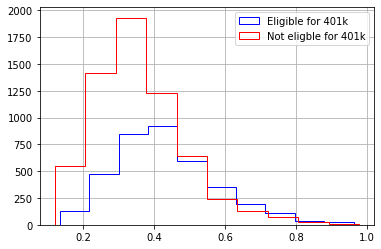

In [115]:
# check common support 
data['clf1'].loc[data['e401']==1].hist(histtype = 'step', color = 'blue', label = 'Eligible for 401k')
data['clf1'].loc[data['e401']==0].hist(histtype = 'step', color = 'red', label = 'Not eligble for 401k')
plt.legend()

In [116]:
# In a similar way, we could tune regressions for potential outcomes when eligibility = 0 and when eligibility = 1
# We could then follow the estimation strategy from above: 
# For cross-fitting
# -divide our datasets in K folds
# -use (K-1) folds to estimate the propensity score model and outcomes models; use left-out fold to estimate ATE according to the AIPW formula above
# -average over K estimators of ATE

# Alternatively we can use off-the-shelf packages Double ML or Econ ML

### Doubly Robust Learner from EconML Package 

https://econml.azurewebsites.net/reference.html#doubly-robust-dr


**Inputs** 
* y = oucome
* T = treatment
* W = nuisance, confounders
* X = when we estimate constant ATE, X can be set to None. This input will be important later for heterogenous treatment effects; it denotes which covariates to consider for heterogeneity

**Key Settings econml.dr.LinearDRLearner**
* model_propensity 
* model_regression
* model_final
* min_propensity
* cv - data partititions for cross-fitting
* mc_iters - how many times to re-run auxiliary models to reduce nuisance 
* mc_agg - how to aggregate estimates from cross-fitting
* random_state

In [117]:
# We start with Doubly Robust Learner from EconMl Package 
# https://econml.azurewebsites.net/reference.html#doubly-robust-dr
from econml.dr import DRLearner, LinearDRLearner

# define our data inputs
y = data['net_tfa'] #oucome
T = data['e401'] #treatment
W = data[['age', 'inc', 'fsize', 'educ', 'db', 'twoearn', 'marr', 'pira', 'hown']] #nuisance, confounders
#X = None #when we estimate ATE, X can be set to None. This will be later used for heterogenous treatment effects; It denotes which covariates to consider for heterogeneity

# settings 
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from econml.dr import DRLearner

est = DRLearner(model_propensity=LogisticRegression(random_state = 1),
                min_propensity = 0.05, 
                model_regression=ensemble.RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=1),
                cv=5, mc_agg = 'median', random_state=1)
est.fit(y, T, X=None, W=W)


In [118]:
# return average treatment effect 
print('Average treatment effect: ', est.effect())

# inference
res = est.effect_inference()
res.population_summary()

Average treatment effect:  [8138.4367164]


### Double Machine Learning from EconML Package

**Key settings**
* model_y
* model_t
* model_final
* linear_first_stages
* discrete_treatment 
* cv
* mc_iters
* mc_agg
* random_state

In [119]:
from econml.dml import DML, LinearDML
est = LinearDML(model_y=ensemble.RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=1),
                model_t=LogisticRegression(random_state = 1),
                discrete_treatment = True, 
                cv=5, mc_agg='mean', random_state = 1)

y = data['net_tfa'] 
T = data['e401']
W = data[['age', 'inc', 'fsize', 'educ', 'db', 'twoearn', 'marr', 'pira', 'hown']]

est.fit(y, T, X=None, W=W)

In [120]:
# return average treatment effect 
print('Average treatment effect: ', est.effect())

# inference
res = est.effect_inference()
res.population_summary()

Average treatment effect:  [8153.58250599]


# 3. Estimation of heterogenous treatment effects 

## Motivation 

**Treatment effect heterogeneity**

Until now we were interested in Average Treatment Effects: $ATE = 𝐸[𝑌_𝑖(1)−𝑌_𝑖(0)]$

In many empirical applications, we are interested in treatment effect heterogeneity and individual treatment effects $\tau_i = Y_i(1) - Y_i(0)$. 

* Policy evaluation: who is benefitting from the treatment? 
* Optimal treatment assignment: how should we assign the treatment? 

While $\tau_i$ is unobserved, we can average over more targeted groups and estimate conditional average treatment effects (CATE): 

$CATE = E[(Y_i(1)-Y_i(0))|Z_i = z]$

**How do economists usually estimate heterogeneity?**

**Issues with the standard approach?** 
* Observational studies
    * Similar problems as with control selections: which dimensions of $Z$ to explore for heterogeneity? 
* RCTs
    * Pre-analysis plans might be too restrictive 

## Adjusting machine learning methods: data-driven ways to estimate heterogeneity

* Athey and Imbens (2016): Causal tree and _honest_ sample-splitting
<br>

* Athey and Wager (2018): Causal forest and theory-based properties
<br>

* Athey, Tibshirani and Wager (2019): Generalized random forests, broader applications
<br>

* Chernozhukov, Demirer, Duflo, and Fernández-Val (2020 Working Paper): Generic machine learning inference on heterogeneous treatment effects

## 3.1 Problem Set-Up 

We focus on the simplest case: randomly assigned treatment. 

For individual $i$ and randomly assigned treatment $D$: 
\begin{equation}
Y_i = Y_i(D_i) = \Bigg\{ \frac{Y_i(1), \ if\  D_i = 1}{Y_i(0), \ otherwise}
\end{equation}

We want to predict unobserved individual treatment effect $\tau_i = Y_i(1) - Y_i(0)$

Instead, we can estimate conditional average treatment effect (CATE): 
\begin{equation}
\tau(z) = \mu_1(z) - \mu_0(z)
\end{equation}

Where $ \mu_d(z) = E(Y_i|D_i = d, Z_i = z)$ - expected outcome, given covariates $z$ and treatment status $d$. 

Main challenges: 
* How to evaluate the impurity/goodness-of-fit? The true $\tau_i$ is unobserved. 
* How to obtain valid standard errors? 

## 3.2 Transformed outcome 

Assume we have a 50/50 randomization, we can transform the outcome $Y_i$ in the following way: 
\begin{equation}
Y_i^* = \Bigg\{ \dfrac{2Y_i,  \ if \ D_i = 1}{-2Y_i, \ if\  D_i = 0}
\end{equation}

Then, we can observe that in expectation our transformation $E(Y_i^*)$ is equal to the expected treatment effect $E(\tau_i)$: 

\begin{equation}
E(Y_i^*) = 2\Big( \dfrac{1}{2}E(Y_i(1)) - \dfrac{1}{2}E(Y_i(0)) \Big) = E(\tau_i)
\end{equation}

You can check that we can generalize this to the treatment with probability $p$: 
$ Y_i^* = \dfrac{D_i - p}{p(1-p)}Y_i $

In observational studies, you can use regression adjustment, propensity score or AIPW scores. 

Idea: using this transformation, we can treat the treatment effect as a dependent variable and use available ML tools (parameteric, functions, tree-based models, ...) to map our inputs $Z_i$ to outputs $ Y_i^*$. The result of this mapping is the prediction of $\tau_i^*$ given $Z_i$, which is equal to the sample mean of $Y_i^*$ within each leaf. 

## 3.3 Athey and Imbens' Causal Tree (CT) Algorithm 

* Provide an extension of the CART algorithm
* Idea: instead of choosing splits to minimize impurity (e.g. MSE), the algorithm chooses tree splits to maximize the squared difference between estimated treatment effects in each child node.
* Intuition: identify subgroups based on covariates $Z$ that have different treatment effects

<br>
    
* **Two contributions**
    * Incorporate _honest estimation_ and show that criteria for both constructing the partition and cross-validation change in its anticipation
    * Propose an alternative in-sample criterion as an _estimator_ for the infeasible in-sample goodness of fit (negative MSE) criterion. 

Infeasible goodness of fit: 
\begin{equation}
    -\dfrac{1}{N}\sum_{i=1}^N(\hat{\tau}_i - \tau_i)
\end{equation}     

Proposed unbiased estimator: 
\begin{equation}
    \dfrac{1}{N}\sum_{i=1}^N(\hat{\tau}_i^2)   
\end{equation} 

You can see full derivations here: https://scholar.princeton.edu/sites/default/files/bstewart/files/lundberg_methods_tutorial_reading_group_version.pdf


## 3.3 Athey and Imbens' Causal Tree (CT) Algorithm 

    
**Algorithm** 
* Given a training set of $(D_i, Z_i, Y_i)$ observations in node $\eta$ of a tree, the estimated treatment effect is 
\begin{equation}
\hat{\tau}_{\eta} = \mu(1,\eta) - \mu(0,\eta)
\end{equation}

    where $\mu(d,\eta)$ is the sample mean of observations in node $\eta$ with treatment status $d$. 
<br>


* Given a node, the split is chosen such that the variance (heterogeneity) of treatment effects across leaves is maximized. 
\begin{equation}
\sum_{k \in left} \hat{\tau}_{left}^2 + \sum_{k \in right} \hat{\tau}_{right}^2
\end{equation}
<br>

* Splitting continues until the $optimal$ number of leaves is attained. 
    * Determined by CV or minimal cost-complexity pruning
    



##  3.3 Athey and Imbens' Causal Tree (CT) Algorithm

**Adaptive vs. Honest CT Algorithms**

_Adaptive algorithm_ uses the training data for both model selection (here: fitting the tree) and for estimation (here: estimating treatment effects)
* Problem: spurious correlations between covariates and outcomes affect the selected model $\rightarrow$ bias

_Honest algorithm_ splits the training data into two parts: one to construct the tree and another one (independent) to estimate treatment effects within leaves of the tree
* Eliminates bias but increases the variance of the estimators 

Athey and Imbens propose a modification to splitting and cross-validation criteria in step 1, which accounts for the estimation on an independent sample in step 2
* Ignore systematic bias in estimation 
* Focus on the trade-off between more personalized prediction (smaller leaf size) and the variance that will arise in the second (honest estimation) step due to noisy estimation within small leaves
    * Safe-guards against using too small leaves
    * "Looks for" covariates that reduce variance in the estimates
    * Unbiased estimates with good standard errors


##  3.3 Athey and Imbens' Causal Tree (CT) Algorithm 
**Summary**

* Important extension of a CART Algorithm
* Relatively easy way to explore heterogeneity in the treatment effects
* But: no personalized predictions (due to restrictions on leaf size)
* But: as other CARTs, CTs result in unstable prediction rules. CV and pruning might be inferior to fitting a simple shallow tree. 
* But: we are likely to generate unbiased estimates with good standard errors, but no theoretical proofs for that so far


## 3.4 Wager and Athey (2018) Estimation and Inference of Heterogeneous Treatment Effects using Random Forests

**Contribution**
* Build on Athey and Imbens (2016) and develop an algorithm for a nonparametric causal forest to estimate heterogeneous 
treatment effects 
* Use model averaging to stabilize the predicted treatment effects
* !Do theory: show that causal forests are pointwise consistent for the true treatment effect and have
an asymptotically Gaussian and centered sampling distribution
* Discuss a method for constructing asymptotic confidence intervals for the true treatment effect
* Bottomline: first set of results proving that random forests can be used for valid statistical inference


## 3.4 Growing the forest 

* Based on Breiman's algorithm for bagging CARTs
* Now: averaging over causal trees 

Given a training set of $\{(D_i, Z_i, Y_i)\}_{i=1}^n$,

Tree predictor:

\begin{equation}
\hat{\tau}(z) = T(z; \{(D_i, Z_i, Y_i)\}_{i=1}^n)
\end{equation} 

Random forest predictor: 

\begin{equation}
\hat{\tau}(z) = \dfrac{1}{B} \sum_{b=1}^B T^*_b(z; \{(D_i, Z_i, Y_i)\}_{i=1}^n)
\end{equation} 

Variation in fitted trees:
* Bagging / **subsampling** the training set 
* Extra randomization 

## 3.4 Main theoretical result: statistical inference with random forests

**Theorem**: Random forests predictors are asymptotically Gaussian and centered, given the following assumptions and technical conditions: 

1. _Honesty_: Individual trees are honest
2. _Subsampling_ (not bootstrapping): Individual trees are built on random subsamples of size $s \sim n^\beta$ with $\beta_0 < \beta < 1$. Rule of thumb = 50\%
3. Continuous covariates $Z_i$
4. Lipschitz response: The conditional mean function $\mu(z) = E(Y|Z=z)$ is Lipschitz continuous

## 3.4 Illustration 

<img src="figures/heat.png" style="height:350px">
Source: Susan Athey (2018) 


# 4 Extensions and complementary work

**S. Athey, J. Tibshirani and S. Wager (2019) Generalized Random Forests**

The authors extend the method of random forests to more applications: estimating conditional means, quantiles, average partial effects.

Key idea: use a forest to calculate a weighted set of neighbors for a given observation 

Applications to:
* Instrumental variable
* Panel regressions
* Quantile regressions
* Survival analysis 

**Chernozhukov, V., Demirer, M., Duflo, E., & Fernandez-Val, I. (2018, revised in 2020). Generic Machine Learning Inference on Heterogeneous Treatment Effects in Randomized Experiments**

* Instead of targeting CATE estimation, target features (predictors) of CATE
* Agnostic about ML methods used; applies to settings with high-dimenstional covariates 


# 5 Implementation  

**R**
* As of now, R offers probably the most developed and stable opportunities to estimate causal HTE using tree-based methods. You can see and replicate the examples from Matt Taddy's Business Data Science book (Chapter 9) here https://github.com/TaddyLab/BDS/blob/master/notebooks/jupyter-examples/Chapter%209.ipynb

**Python**
* Econ ML package https://econml.azurewebsites.net/spec/motivation.html developed by Microsoft's ALICE project looks promising. It implements estimations from recent academic works, as well as from in-house Microsoft research. In addition, to the methods covered in the lecture, the package comprises many other solutions, such as Double Machine Learning, Deep Instrumental Variables, Non-parametric Instrumental Variables, meta-learners, etc. 


## Illustration with EconML Package 

In [128]:
#https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html#econml.dml.CausalForestDML
    
from econml.dml import CausalForestDML

y = data['net_tfa'] 
T = data['e401']
W = data[['age', 'inc', 'fsize', 'educ', 'db', 'twoearn', 'marr', 'pira', 'hown']]
X = data[['age', 'inc', 'fsize', 'educ', 'db', 'twoearn', 'marr', 'pira', 'hown']] #you can specify other dimensions of X 
 
# here we define the models for y and t (we can choose also simple Linear Regressions, Lasso, etc..)
fit_t =ensemble.RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1,  \
        random_state = 1)
#fit_t = LogisticRegression(random_state = 1) 
fit_y = ensemble.RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=1)
# Note, it is also possible to tune the parameters for all the fitted regressions, as well as to select a model that fits the best
# Check the implementation here: https://github.com/microsoft/EconML/blob/master/notebooks/ForestLearners%20Basic%20Example.ipynb

est = CausalForestDML(model_y= fit_y, 
                model_t=fit_t,
                discrete_treatment=True,
                n_estimators=100,
                honest = True, # default
                inference = True, 
                min_samples_leaf=20,
                random_state = 1)
est.fit(y, T, X=X, W=W) 


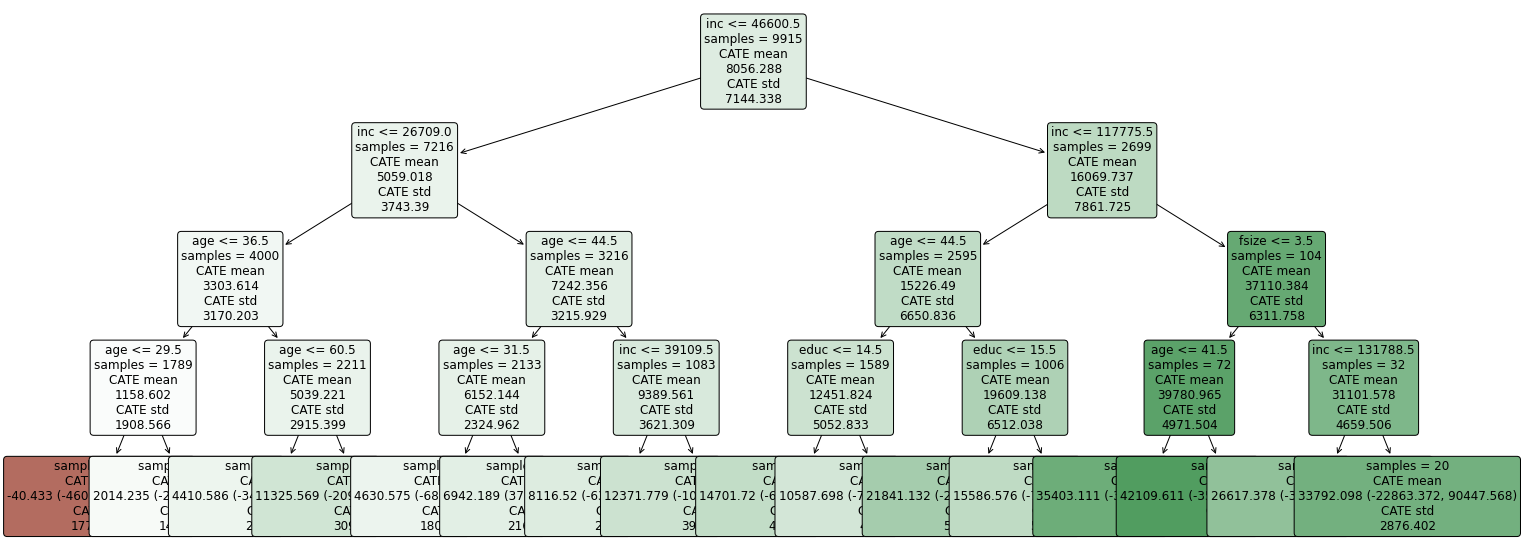

In [129]:
# which features seem to be important 
from econml.cate_interpreter import SingleTreeCateInterpreter
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrp.interpret(est, X)
plt.figure(figsize=(25, 10))
intrp.plot(feature_names=X.columns, fontsize=12)

In [130]:
# feature importance 
imp = pd.DataFrame(est.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)

,Feature importance,Feature
0,0.698716,inc
1,0.156965,age
2,0.083499,educ
3,0.019635,pira
4,0.014415,fsize
5,0.014008,twoearn
6,0.007027,db
7,0.004765,marr
8,0.000971,hown


In [131]:
# we get estimated treatment effects with 90% confidence intervals 
te_pred = est.effect(X)
te_pred_interval = est.effect_interval(X)
res = est.effect_inference(X)
# you can also use est.effect_inference(X) to obtain full information (point estimate, se, pvalue, bounds)
# about estimated treatment effects 
res.population_summary()

<AxesSubplot:>

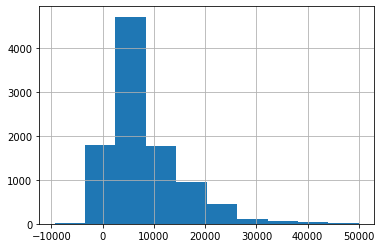

In [132]:
# some visualization
out = data.copy()
out['te_pred'] = te_pred
out = out.join(pd.DataFrame(np.transpose(te_pred_interval), columns=['lb', 'ub']))
out['te_pred'].hist()

<AxesSubplot:xlabel='inc', ylabel='te_pred'>

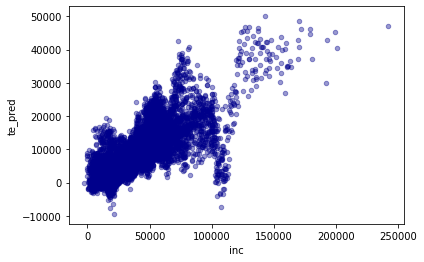

In [133]:
out.plot.scatter(y = 'te_pred', x = 'inc',  c='DarkBlue', alpha = 0.4)

# Resources 

S Athey, G Imbens. Recursive partitioning for heterogeneous causal effects.  Proceedings of the National Academy of Sciences 113 (27), 7353-7360, 2016.

S. Wager and S. Athey. Estimation and inference of heterogeneous treatment effects using random forests. Journal of the American Statistical Association, 113(523), pp.1228-1242, 2018.

S. Athey, J. Tibshirani and S. Wager. Generalized Random Forests. Annals of Statistics, 2019

Chernozhukov, V., Demirer, M., Duflo, E., & Fernandez-Val, I. (2018, revised in 2020). Generic Machine Learning Inference on Heterogeneous Treatment Effects in Randomized Experiments, with an Application to Immunization in India (No. w24678). National Bureau of Economic Research.

Susan Athey and Stefan Wager 2021 Stanford Short Online Course 'Machine Learning and Economics'
https://www.youtube.com/watch?v=Z0ZcsxI-HTs&list=PLxq_lXOUlvQAoWZEqhRqHNezS30lI49G-
In particular lectures on Average Treatment and Conditional Average Treatment Effects

Susan Athey's lectures on Machine Learning (Parts 3 - 4) 
https://www-aeaweb-org.emedien.ub.uni-muenchen.de/conference/cont-ed/2018-webcasts

